In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF, TruncatedSVD

## Visualise library

In [3]:
# read in spectral library
f = 'reflectance/resources/spectral_library_clean_v3_PRISM_wavebands.csv'
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)

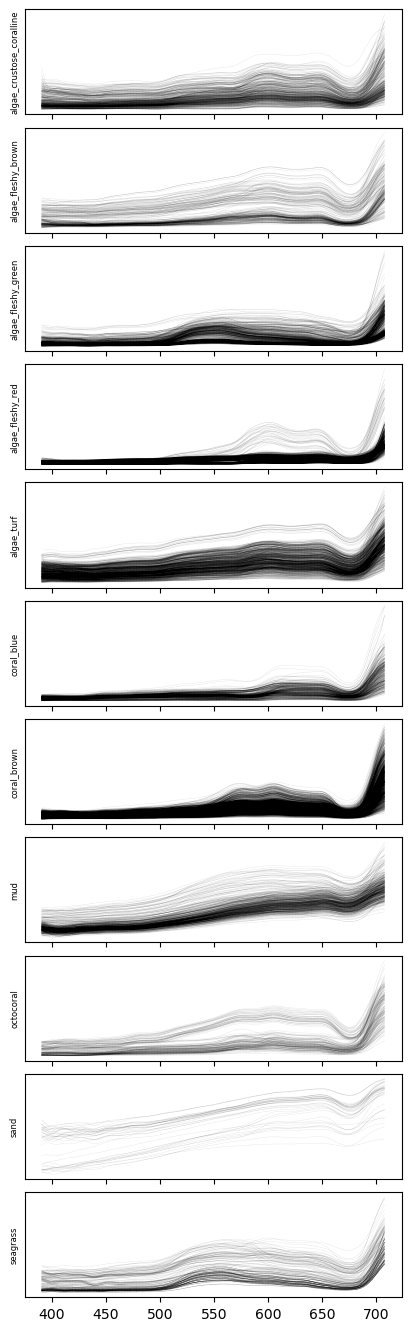

In [11]:
cats = df.index.unique()

fig, axs = plt.subplots(len(cats), 1, figsize=[4, len(cats) * 1.2], sharex=True, constrained_layout=True)

for c, ax in zip(cats, axs):
    ind = df.index == c
    ax.plot(df.columns, df.loc[ind].values.T, color='k', alpha=0.05, lw=0.3)
    
    ax.plot(df.columns, df.loc[ind].values.T, color='k', alpha=0.05, lw=0.3)
    
    ax.set_ylabel(c, fontsize=6)
    ax.set_yticks([])

### PCA

(390.3468145, 707.7733348)

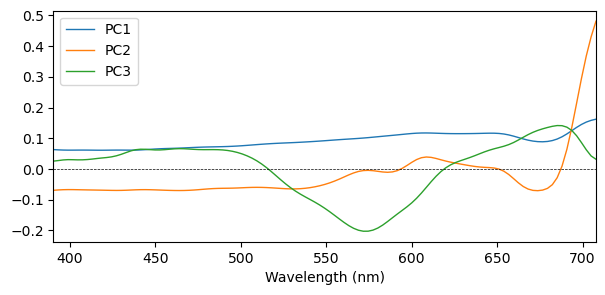

In [47]:

# N-component PCA
pca = PCA(3)
pca.fit_transform(df)

fig, ax = plt.subplots(figsize=[7, 3])
for i, component in enumerate(pca.components_):
    ax.plot(df.columns, component, label=f'PC{i+1}', lw=1)
ax.hlines(0, df.columns.min(), df.columns.max(), color='k', lw=0.5, ls='--')

# formatting
ax.legend()
ax.set_xlabel('Wavelength (nm)')
ax.set_xlim(df.columns.min(), df.columns.max())

In [45]:
pca.explained_variance_ratio_.cumsum()

array([0.91105596, 0.97373966, 0.98561967])

### Truncated SVD

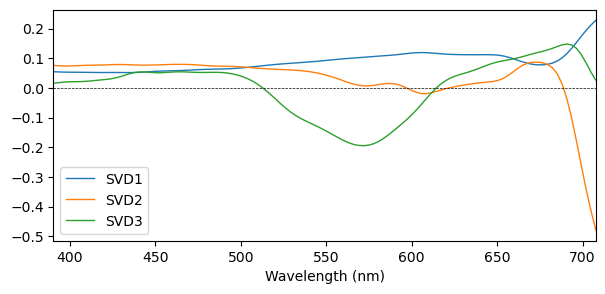

In [46]:
svd = TruncatedSVD(3)
svd.fit_transform(df)

fig, ax = plt.subplots(figsize=[7, 3])
for i, component in enumerate(svd.components_):
    ax.plot(df.columns, component, label=f'SVD{i+1}', lw=1)
ax.hlines(0, df.columns.min(), df.columns.max(), color='k', lw=0.5, ls='--')
 
# formatting
ax.set_xlabel('Wavelength (nm)')
ax.set_xlim(df.columns.min(), df.columns.max())
ax.legend()    

In [43]:
svd.explained_variance_ratio_.cumsum()

array([0.8979756 , 0.97263838, 0.98511882])